# Dualing Deep Q-Network

This approach is particularly useful in states where choosing an action doesn’t make a big difference. For example, in situations where any action would yield a similar result, Dueling DQN can avoid unnecessary computations, making learning more efficient and focused.

Example: Picture an AI agent navigating a maze. In certain locations, like a dead end, moving left or right doesn’t impact the outcome much. Dueling DQN helps the agent recognize these unimportant actions, allowing it to focus on critical decision points, like exits or junctions, resulting in faster and more focused learning.

In [1]:
%pip install numpy torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, adv_type = 'avg', fc1_units=128, fc2_units=64,fc3_units = 256):
        super(QNetwork, self).__init__()

        # State to first hidden layer
        self.fc1 = nn.Linear(state_size, fc1_units)

        # From first to second hidden layer
        self.fc2 = nn.Linear(fc1_units, fc2_units)

        # From second to third layer, separate state value and action advantage
        self.fc_adv = nn.Linear(fc2_units, fc3_units)
        self.fc_value = nn.Linear(fc2_units, fc3_units)

        # Map to state and action logits
        self.adv = nn.Linear(fc3_units, action_size)
        self.value = nn.Linear(fc3_units, 1)

        self.adv_type = adv_type

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        # State value
        x_value = F.relu(self.fc_value(x))
        x_value = F.relu(self.adv(x_value))

        # Action advantage
        x_adv = F.relu(self.fc_adv(x))
        x_adv = F.relu(self.adv(x_adv))

        if self.adv_type == 'avg':
          advAverage = torch.mean(x_adv, dim=1, keepdim=True)
          q =  x_value + x_adv - advAverage
        else:
          advMax,_ = torch.max(x_adv, dim=1, keepdim=True)
          q =  x_value + x_adv - advMax
        return q

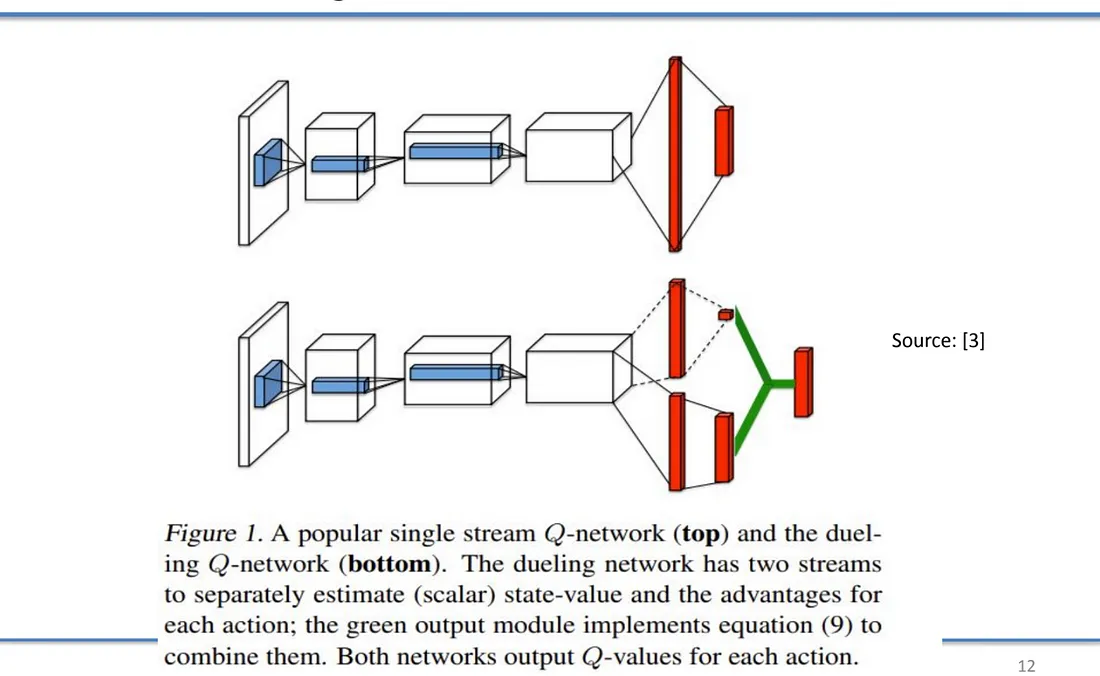

## Combination of value and advantage stream

The aggregation is done in such a way that it maintains a RELATIVE advantage of each action while ensuring that the Q-values are grounded in the actual value of being in that state.

This is often achieved by subtracting the mean or the max of the Advantage stream from each action’s advantage, ensuring that the value function remains the primary determinant of the Q-value.

